In [1]:
import os
import sys
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader
from iblatlas.regions import BrainRegions

from sklearn import linear_model as sklm
from sklearn.metrics import accuracy_score, balanced_accuracy_score, r2_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from behavior_models.utils import format_data as format_data_mut
from behavior_models.utils import format_input as format_input_mut

from brainwidemap.bwm_loading import load_good_units, load_all_units, load_trials_and_mask, merge_probes
from brainwidemap.decoding.functions.process_targets import load_behavior
from brainwidemap.decoding.settings_for_BWM_figure.settings_choice import params
from brainwidemap.decoding.settings_for_BWM_figure.settings_choice import RESULTS_DIR

from brainwidemap.decoding.functions.balancedweightings import balanced_weighting
from brainwidemap.decoding.functions.process_inputs import (
    build_predictor_matrix,
    select_ephys_regions,
    preprocess_ephys
)
from brainwidemap.decoding.functions.process_targets import (
    compute_beh_target,
    compute_target_mask,
    transform_data_for_decoding,
    logisticreg_criteria,
    get_target_data_per_trial_wrapper,
    check_bhv_fit_exists,
    optimal_Bayesian
)
from brainwidemap.decoding.functions.utils import save_region_results, get_save_path
from brainwidemap.decoding.functions.nulldistributions import generate_null_distribution_session
from brainwidemap.decoding.functions.decoding import decode_cv

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [2]:
def reduced_rank_close_form(X_c, Y_c, R, penalty):
    
    K, T, C = X_c.shape
    
    # compute U
    S_t = np.einsum("ktc,kdn->ctdn", X_c, X_c)
    
    I = np.eye(C*T)
    np.fill_diagonal(I, penalty)
    I = I.reshape(C, T, T, C)
    S_t = S_t + I
    
    D = np.eye(C*T)
    np.fill_diagonal(D, 1/np.diag(S_t.reshape(C*T, T*C)))
    D = np.sqrt(D).reshape(C,T,T,C)
    D[np.isnan(D)] = np.nanmean(D)

    XY = (X_c.T @ Y_c).reshape(C,T)
                     
    U, _, _ = np.linalg.svd(XY)
    U = U[:,:R]
    
    # compute V
    G_part = np.einsum("cr, ctdn->rtdn", U, S_t)
    G = np.einsum("rtdn, ns->rs", G_part, U)
    H = U.T @ (X_c.T @ Y_c).squeeze()
    V = np.linalg.inv(G) @ H
    
    return U, V

### load data

In [3]:
roi = "CA1"

In [4]:
print(params['target'])
params['behfit_path'] = RESULTS_DIR.joinpath('decoding', 'results', 'behavioral')
params['behfit_path'].mkdir(parents=True, exist_ok=True)
params['neuralfit_path'] = RESULTS_DIR.joinpath('decoding', 'results', 'neural')
params['neuralfit_path'].mkdir(parents=True, exist_ok=True)
params['add_to_saving_path'] = (f"_binsize={1000 * params['binsize']}_lags={params['n_bins_lag']}_"
                                f"mergedProbes_{params['merged_probes']}")
imposter_file = RESULTS_DIR.joinpath('decoding', f"imposterSessions_{params['target']}.pqt")
bwm_session_file = RESULTS_DIR.joinpath('decoding', 'bwm_cache_sessions.pqt')
print(params["align_time"])
params["time_window"] = (-0.5, 1.5)
print(params["time_window"])
params["binsize"] = 0.05
print(params["binsize"])
params['n_pseudo'] = 0
params['n_runs'] = 1

one = ONE(base_url="https://openalyx.internationalbrainlab.org", mode='remote')
bwm_df = pd.read_parquet(bwm_session_file)

pids_per_region = one.search_insertions(atlas_acronym=[roi], query_type='remote')
print(len(pids_per_region))

bwm_df = bwm_df.loc[bwm_df.pid.isin(pids_per_region)]
unit_type = "all_units"
dir_path = Path("/home/yizi/decode-brain-wide-map/results")/roi


choice
stimOn_times
(-0.5, 1.5)
0.05
201


In [5]:
# res_by_eids = {}

1 / 61 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 6713a4a7-faed-4df2-acab-ee4e63326f8d
/home/yizi/decode-brain-wide-map/results/CA1/6713a4a7-faed-4df2-acab-ee4e63326f8d/stimOn_times_-0.5_1.5_0.05_all_units.npy
error loading choice data

Working on eid: 6713a4a7-faed-4df2-acab-ee4e63326f8d


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

CA1
# units: 43



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_36448/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:05<00:20,  5.02s/it]/tmp/ipykernel_36448/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:09<00:14,  4.98s/it]/tmp/ipykernel_36448/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:14<00:09,  4.65s/it]/tmp/ipykernel_36448/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:18<00:04,  4.66s/it]/tmp/ipykernel_36448/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.527 auc:  0.583
reduced-rank acc:  0.549 auc:  0.560


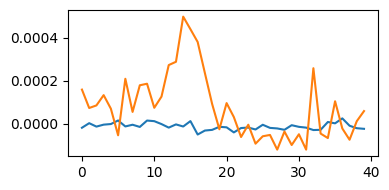

Finished eid: 6713a4a7-faed-4df2-acab-ee4e63326f8d
[0.526609546434176, 0.5827109299275215, 0.5493528921379618, 0.5601053744464686]


In [111]:
n_sess = bwm_df.shape[0] if bwm_df.shape[0] <= 15 else 15
for idx in range(n_sess):
    
    print(f"{idx+1} / {bwm_df.shape[0]+1} ...")
    
    job_repeat = 0 
    pseudo_ids = np.arange(job_repeat * params['n_pseudo_per_job'], (job_repeat + 1) * params['n_pseudo_per_job']) + 1
    if 1 in pseudo_ids:
        pseudo_ids = np.concatenate((-np.ones(1), pseudo_ids)).astype('int64')
    if pseudo_ids[0] > params['n_pseudo']:
        print(f"ended job because this job_repeat ({job_repeat}) does not include any pseudo sessions < {params['n_pseudo']}")
        exit()
    if pseudo_ids[-1] > params['n_pseudo']:
        print(f"truncated job because this job_repeat ({job_repeat}) includes more than {params['n_pseudo']} pseudo sessions")
        pseudo_ids = pseudo_ids[pseudo_ids <= params['n_pseudo']]

    if params['merged_probes']:
        eid = bwm_df['eid'].unique()[idx]
        tmp_df = bwm_df.set_index(['eid', 'subject']).xs(eid, level='eid')
        subject = tmp_df.index[0]
        pids = tmp_df['pid'].to_list()  # Select all probes of this session
        probe_names = tmp_df['probe_name'].to_list()
        print(f"Running merged probes for session eid: {eid}")
    else:
        eid = bwm_df.iloc[idx]['eid']
        subject = bwm_df.iloc[idx]['subject']
        pid = bwm_df.iloc[idx]['pid']
        probe_name = bwm_df.iloc[idx]['probe_name']
        print(f"Running probe pid: {pid}")
        
    if not os.path.exists(dir_path/eid):
        os.makedirs(dir_path/eid)
        
    res_path = dir_path/eid/f'{params["align_time"]}_{params["time_window"][0]}_{params["time_window"][1]}_{params["binsize"]}_{unit_type}.npy'
    print(res_path)

    sess_loader = SessionLoader(one, eid)
    sess_loader.load_trials()

    trials_df, trials_mask = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=params['min_rt'], max_rt=params['max_rt'],
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_without_minrt = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=None, max_rt=params['max_rt'],
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_without_maxrt = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=params['min_rt'], max_rt=None,
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_withonly_nochoice = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=None, max_rt=None,
        min_trial_len=None, max_trial_len=None,
        exclude_nochoice=True, exclude_unbiased=False)

    params['trials_mask_diagnostics'] = [trials_mask,
                                         trials_mask_without_minrt,
                                         trials_mask_without_maxrt,
                                         trials_mask_withonly_nochoice]

    # if params['target'] in ['wheel-vel', 'wheel-speed', 'l-whisker-me', 'r-whisker-me']:
    if params['target'] in ['choice', 'wheel-vel', 'wheel-speed', 'l-whisker-me', 'r-whisker-me']:
        # load target data
        dlc_dict = load_behavior(params['target'], sess_loader)
        # load imposter sessions
        params['imposter_df'] = pd.read_parquet(imposter_file) if params['n_pseudo'] > 0 else None
    else:
        dlc_dict = None
        params['imposter_df'] = None

    if params['merged_probes']:
        clusters_list = []
        spikes_list = []
        for pid, probe_name in zip(pids, probe_names):
            # tmp_spikes, tmp_clusters = load_good_units(one, pid, eid=eid, pname=probe_name)
            tmp_spikes, tmp_clusters = load_all_units(one, pid, eid=eid, pname=probe_name)
            tmp_clusters['pid'] = pid
            spikes_list.append(tmp_spikes)
            clusters_list.append(tmp_clusters)
        spikes, clusters = merge_probes(spikes_list, clusters_list)
    else:
        # spikes, clusters = load_good_units(one, pid, eid=eid, pname=probe_name)
        spikes, clusters = load_all_units(one, pid, eid=eid, pname=probe_name)

    neural_dict = {
        'spk_times': spikes['times'],
        'spk_clu': spikes['clusters'],
        'clu_regions': clusters['acronym'],
        'clu_qc': {k: np.asarray(v) for k, v in clusters.to_dict('list').items()},
        'clu_df': clusters
    }

    metadata = {
        'subject': subject,
        'eid': eid,
        'probe_name': probe_name
    }
    
    kwargs = params
    kwargs['n_runs'] = 1
    kwargs['n_bins_lag'] = 0
    
    # select brain regions from beryl atlas to loop over
    brainreg = BrainRegions()
    beryl_reg = brainreg.acronym2acronym(neural_dict['clu_regions'], mapping='Beryl')
    regions = (
        [[k] for k in np.unique(beryl_reg)] if kwargs['single_region'] else [np.unique(beryl_reg)])
    
    if [roi] not in regions:
        print(f"{roi} not found. Skip to next eid.")
        continue
    
    print(f'Working on eid: {metadata["eid"]}')
    filenames = []  # this will contain paths to saved decoding results for this eid

    # kwargs['use_imposter_session'] = True # turn on for bin_size > 1
    kwargs['use_imposter_session'] = False
    if kwargs['use_imposter_session'] and not kwargs['stitching_for_imposter_session']:
        trials_df = trials_df[:int(kwargs['max_number_trials_when_no_stitching_for_imposter_session'])]

    if 0 in pseudo_ids:
        raise ValueError(
            'pseudo id can be -1 (actual session) or strictly greater than 0 (pseudo session)')

    if not np.all(np.sort(pseudo_ids) == pseudo_ids):
        raise ValueError('pseudo_ids must be sorted')

    if kwargs['model'] == optimal_Bayesian and np.any(trials_df.probabilityLeft.values[:90] != 0.5):
        raise ValueError(
            'The optimal Bayesian model assumes 90 unbiased trials at the beginning of the '
            'session, which is not the case here.')

    # check if is trained
    eids_train = (
        [metadata['eid']] if 'eids_train' not in metadata.keys() else metadata['eids_train'])
    if 'eids_train' not in metadata.keys():
        metadata['eids_train'] = eids_train
    elif metadata['eids_train'] != eids_train:
        raise ValueError(
            'eids_train are not supported yet. If you do not understand this error, '
            'just take out the eids_train key in the metadata to solve it')

    if isinstance(kwargs['model'], str):
        import pickle
        from braindelphi.params import INTER_INDIVIDUAL_PATH
        inter_individual = pickle.load(open(INTER_INDIVIDUAL_PATH.joinpath(kwargs['model']), 'rb'))
        if metadata['eid'] not in inter_individual.keys():
            logging.exception('no inter individual model found')
            print(filenames)
        inter_indiv_model_specifications = inter_individual[metadata['eid']]
        print('winning interindividual model is %s' % inter_indiv_model_specifications['model_name'])
        if inter_indiv_model_specifications['model_name'] not in kwargs['modeldispatcher'].values():
            logging.exception('winning inter individual model is LeftKernel or RightKernel')
            print(filenames)
        kwargs['model'] = {v: k for k, v in kwargs['modeldispatcher'].items()}[inter_indiv_model_specifications['model_name']]
        kwargs['model_parameters'] = inter_indiv_model_specifications['model_parameters']
    else:
        kwargs['model_parameters'] = None
        # train model if not trained already
        if kwargs['model'] != optimal_Bayesian and kwargs['model'] is not None:
            side, stim, act, _ = format_data_mut(trials_df)
            stimuli, actions, stim_side = format_input_mut([stim], [act], [side])
            behmodel = kwargs['model'](
                kwargs['behfit_path'], np.array(metadata['eids_train']), metadata['subject'],
                actions, stimuli, trials_df, stim_side, single_zeta=True)
            istrained, _ = check_bhv_fit_exists(
                metadata['subject'], kwargs['model'], metadata['eids_train'],
                kwargs['behfit_path'], modeldispatcher=kwargs['modeldispatcher'], single_zeta=True)
            if not istrained:
                behmodel.load_or_train(remove_old=False)

    if kwargs['balanced_weight'] and kwargs['balanced_continuous_target']:
        raise NotImplementedError("see tag `decoding_biasCWnull` for a previous implementation.")
    else:
        target_distribution = None

    # get target values
    if kwargs['target'] in ['pLeft', 'signcont', 'strengthcont', 'choice', 'feedback']:
        target_vals_list, target_vals_to_mask = compute_beh_target(
            trials_df, metadata, return_raw=True, **kwargs)
        target_mask = compute_target_mask(
            target_vals_to_mask, kwargs['exclude_trials_within_values'])

    else:
        if dlc_dict is None or dlc_dict['times'] is None or dlc_dict['values'] is None:
            raise ValueError('dlc_dict does not contain any data')
        _, target_vals_list, target_mask = get_target_data_per_trial_wrapper(
            target_times=dlc_dict['times'],
            target_vals=dlc_dict['values'],
            trials_df=trials_df,
            align_event=kwargs['align_time'],
            align_interval=kwargs['time_window'],
            binsize=kwargs['binsize'])

    mask = trials_mask & target_mask

    if sum(mask) <= kwargs['min_behav_trials']:
        msg = 'session contains %i trials, below the threshold of %i' % (
            sum(mask), kwargs['min_behav_trials'])
        logging.exception(msg)
        print(filenames)
        
    roi_idx = np.argwhere(np.array([region[0].find(roi) for region in regions]) == 0).astype(int)
    regions = regions[roi_idx[0][0]]
    for region in tqdm(regions, desc='Region: ', leave=False):
        
        print(regions[0])
        # pull spikes from this region out of the neural data
        reg_clu_ids = select_ephys_regions(neural_dict, beryl_reg, region, **kwargs)

        # skip region if there are not enough units
        n_units = len(reg_clu_ids)
        if n_units < kwargs['min_units']:
            continue
        print(f"# units: {n_units}")

        # bin spikes from this region for each trial
        msub_binned, cl_inds_used = preprocess_ephys(reg_clu_ids, neural_dict, trials_df, **kwargs)
        cl_uuids_used = list(neural_dict['clu_df'].iloc[cl_inds_used]['uuids'])

        # make design matrix
        bins_per_trial = msub_binned[0].shape[0]
        Xs = (
            msub_binned if bins_per_trial == 1
            else [build_predictor_matrix(s, kwargs['n_bins_lag']) for s in msub_binned]
        )
        
        # reduced rank model
        X = np.array(Xs)
        Y = np.array(target_vals_list)
        Y_c = (Y - Y.mean()).reshape(-1,1)
        X_c = X - X.mean()
        
        n_folds = 5
        penalty = [1e-4, 1e-3, 1e-2, 1, 1e1, 1e2, 1e3, 1e4]

        baseline_accs, baseline_aucs = [], []
        rrr_accs, rrr_aucs = [], []
        Us, Vs = [], []

        skf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
        for train, test in tqdm(skf.split(X, Y), total=n_folds):

            K,T,C = X.shape

            X_train, X_test, Y_train, Y_test = X[train], X[test], Y[train], Y[test]
            decoder = GridSearchCV(sklm.LogisticRegression(max_iter=10000), {"C": penalty})
            decoder.fit(X_train.reshape((-1,T*C)), Y_train)
            yhat = decoder.predict(X_test.reshape((-1,T*C)))
            prob = decoder.predict_proba(X_test.reshape((-1,T*C)))[:,1]
            acc = balanced_accuracy_score(Y_test, yhat)
            auc = roc_auc_score(Y_test, prob)
            baseline_accs.append(acc)
            baseline_aucs.append(auc)

            X_train, X_test, Y_train, Y_test = X_c[train], X_c[test], Y_c[train], Y_c[test]
            U, V = reduced_rank_close_form(X_train, Y_train, R=2, penalty=0)
            Y_train, Y_test = Y[train], Y[test]
            Yhat_train = np.einsum("ktr,rt->k", X_train @ U, V)
            Yhat_test = np.einsum("ktr,rt->k", X_test @ U, V)

            decoder = GridSearchCV(sklm.LogisticRegression(max_iter=10000), {"C": penalty})
            decoder.fit(Yhat_train.reshape(-1,1), Y_train)
            Yhat = decoder.predict(Yhat_test.reshape(-1,1))

            acc = balanced_accuracy_score(Y_test, Yhat)
            auc = roc_auc_score(Y_test, Yhat_test)
            rrr_accs.append(acc)
            rrr_aucs.append(auc)
            Us.append(U)
            Vs.append(V)

        print(f"baseline acc: {np.mean(baseline_accs): .3f} auc: {np.mean(baseline_aucs): .3f}")
        print(f"reduced-rank acc: {np.mean(rrr_accs): .3f} auc: {np.mean(rrr_aucs): .3f}")

        Us = np.array(Us).mean(0)
        Vs = np.array(Vs).mean(0).T

        plt.figure(figsize=(4,2))
        plt.plot(Vs)
        plt.tight_layout()
        plt.show()
        
            
    res = []
    for filename in filenames:
        with open(filename, 'rb') as f:
            res.append(pickle.load(f))

    res_by_eids.update({eid: {}})
    res_by_eids[eid].update({"metrics": [np.mean(baseline_accs), np.mean(baseline_aucs), np.mean(rrr_accs), np.mean(rrr_aucs)]})            
    res_by_eids[eid].update({"UV": [Us, Vs]})            
    
    print(f'Finished eid: {metadata["eid"]}')
    print(res_by_eids[eid]["metrics"])
    np.save(res_path, res_by_eids)